In [2]:
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('../util')
sys.path.append('/Users/joyceduan/documents/git2/machine_learning')
sys.path.append('/Users/joyceduan/documents/git2/machine_learning/features')
import myutil
import ml_util  
import features

In [3]:
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
%matplotlib inline


In [4]:
def read_data(datafname):
    df = pd.read_csv(datafname)
    df.columns = [myutil.camel_to_snake(c) for c in df.columns]
    print df.columns
    df.rename(columns={'unnamed: 0':'id'}, inplace=True)
    df.columns = [u'id', u'dlqin2yrs', u'revolv_util_unsec_lines', u'age', u'n_30-59d_late', \
                  u'debt_income_ratio', u'monthly_income', u'n_openloans_creditlines', \
                  u'n_90d_late', u'n_realestate_loans', u'n_60-89d_late', u'n_dependents']
    cols_reordered = [u'id', u'dlqin2yrs', u'age', u'revolv_util_unsec_lines',  u'debt_income_ratio'\
                      , u'monthly_income', u'n_openloans_creditlines', u'n_realestate_loans',  u'n_dependents',\
                      u'n_30-59d_late',u'n_60-89d_late', u'n_90d_late']
    df = df[cols_reordered]
    yname = df.columns[1]
    xnames = df.columns[2:]
    return df, xnames, yname

In [5]:
df, xnames, yname = read_data('data/credit-training.csv')

Index([u'unnamed: 0', u'serious_dlqin2yrs', u'revolving_utilization_of_unsecured_lines', u'age', u'number_of_time30-59_days_past_due_not_worse', u'debt_ratio', u'monthly_income', u'number_of_open_credit_lines_and_loans', u'number_of_times90_days_late', u'number_real_estate_loans_or_lines', u'number_of_time60-89_days_past_due_not_worse', u'number_of_dependents'], dtype='object')


In [68]:
print "shape: ", df.shape

shape:  (150000, 12)


In [69]:
df.head().T

,0,1,2,3,4
id,1.000000,2.000000,3.000000,4.00000,5.000000
dlqin2yrs,1.000000,0.000000,0.000000,0.00000,0.000000
age,45.000000,40.000000,38.000000,30.00000,49.000000
revolv_util_unsec_lines,0.766127,0.957151,0.658180,0.23381,0.907239
debt_income_ratio,0.802982,0.121876,0.085113,0.03605,0.024926
monthly_income,9120.000000,2600.000000,3042.000000,3300.00000,63588.000000
n_openloans_creditlines,13.000000,4.000000,2.000000,5.00000,7.000000
n_realestate_loans,6.000000,0.000000,0.000000,0.00000,1.000000
n_dependents,2.000000,1.000000,0.000000,0.00000,0.000000
n_30-59d_late,2.000000,0.000000,1.000000,0.00000,1.000000


In [70]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,150000,75000.500000,43301.414527,1,37500.750000,75000.500000,112500.250000,150000
dlqin2yrs,150000,0.066840,0.249746,0,0.000000,0.000000,0.000000,1
age,150000,52.295207,14.771866,0,41.000000,52.000000,63.000000,109
revolv_util_unsec_lines,150000,6.048438,249.755371,0,0.029867,0.154181,0.559046,50708
debt_income_ratio,150000,353.005076,2037.818523,0,0.175074,0.366508,0.868254,329664
monthly_income,120269,6670.221237,14384.674215,0,3400.000000,5400.000000,8249.000000,3008750
n_openloans_creditlines,150000,8.452760,5.145951,0,5.000000,8.000000,11.000000,58
n_realestate_loans,150000,1.018240,1.129771,0,0.000000,1.000000,2.000000,54
n_dependents,146076,0.757222,1.115086,0,0.000000,0.000000,1.000000,20
n_30-59d_late,150000,0.421033,4.192781,0,0.000000,0.000000,0.000000,98


In [71]:
print ml_util.count_null(df)

                         not_null   null  pct_null
variable                                          
age                        150000      0         0
debt_income_ratio          150000      0         0
dlqin2yrs                  150000      0         0
id                         150000      0         0
monthly_income             120269  29731        19
n_30-59d_late              150000      0         0
n_60-89d_late              150000      0         0
n_90d_late                 150000      0         0
n_dependents               146076   3924         2
n_openloans_creditlines    150000      0         0
n_realestate_loans         150000      0         0
revolv_util_unsec_lines    150000      0         0


## summary stats y

In [72]:
icol_y = 1
print '%i total samples, %i positives %.2f%%' % \
(df.shape[0], df.iloc[:,icol_y].sum(),100.0* df.iloc[:,icol_y].sum()/df.shape[0])
unique, counts = np.unique(df.iloc[:,icol_y], return_counts=True)
print 'counts by y'
print np.asarray((unique, counts)).T

150000 total samples, 10026 positives 6.68%
counts by y
[[     0 139974]
 [     1  10026]]


- im-balanced class, 6.7% positive. need adjust models accordinly.

## summary stats X - Univariate

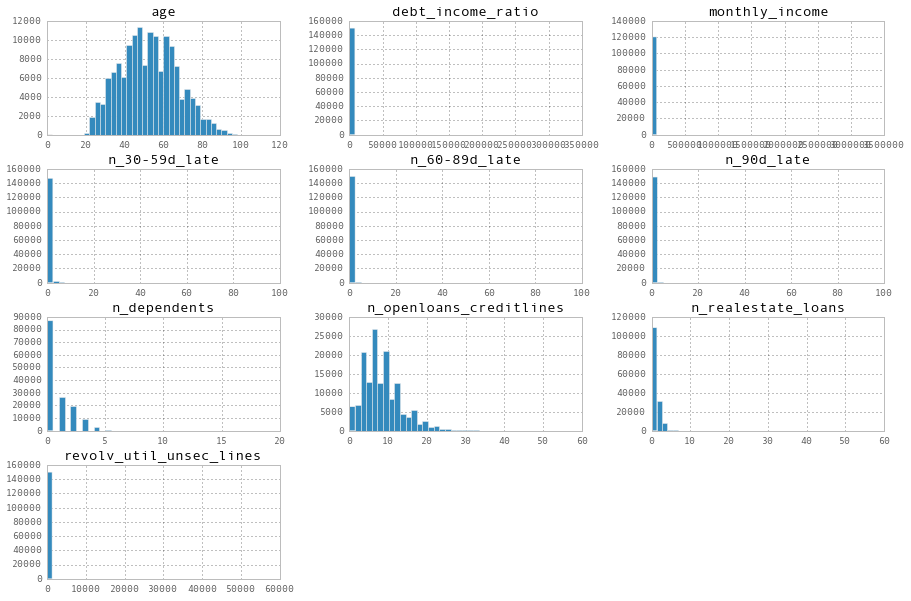

In [6]:
colname_id = 'id'
colname_y = 'dlqin2yrs'
colnames_X = df.columns - [colname_id, colname_y]
df[colnames_X].hist( bins= 40, figsize=(15, 10))
plt.show()

In [95]:
#df.monthly_income.quantile(99.9/100)

df[colnames_X].quantile(99.9/100)

age                           94.000
debt_income_ratio          10613.074
monthly_income             78395.748
n_30-59d_late                 98.000
n_60-89d_late                 98.000
n_90d_late                    98.000
n_dependents                   6.000
n_openloans_creditlines       34.000
n_realestate_loans             9.000
revolv_util_unsec_lines     1571.006
dtype: float64

In [7]:
df_x_capped = features.cap_df(df,colnames_X, pct = 0.99)
print "\n", "historgram after capping"
#hists(df_x_capped, df_x_capped.columns)


historgram after capping



historgram after capping


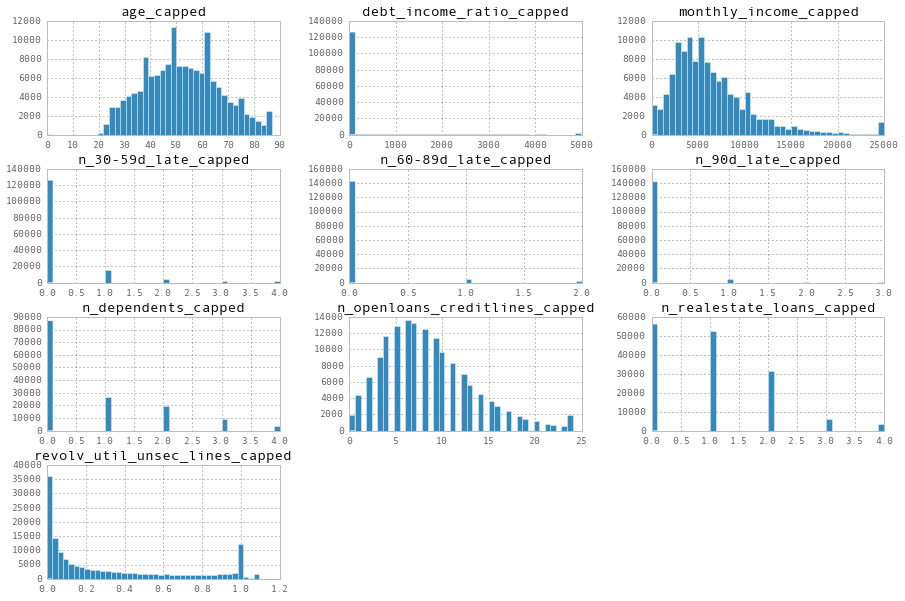

In [75]:
df_x_capped.hist( bins= 40, figsize=(15, 10))
plt.show()

In [8]:
print df.columns
df2 = pd.concat([df, df_x_capped], axis = 1)

Index([u'id', u'dlqin2yrs', u'age', u'revolv_util_unsec_lines', u'debt_income_ratio', u'monthly_income', u'n_openloans_creditlines', u'n_realestate_loans', u'n_dependents', u'n_30-59d_late', u'n_60-89d_late', u'n_90d_late'], dtype='object')


In [141]:
threashhold = 400
f = lambda x: x <= threashhold
operator = '=='
col_name = 'monthly_income'
cond = df[col_name].apply(f)
cnt = df[cond][col_name].count()
pct = 100.0 * cnt / df.shape[0]
print '%s %s %.2f cnt: %i  pct: %.2f' % (col_name, operator, threashhold, cnt, pct)

monthly_income == 400.00 cnt: 2610  pct: 1.74


## Bivariate

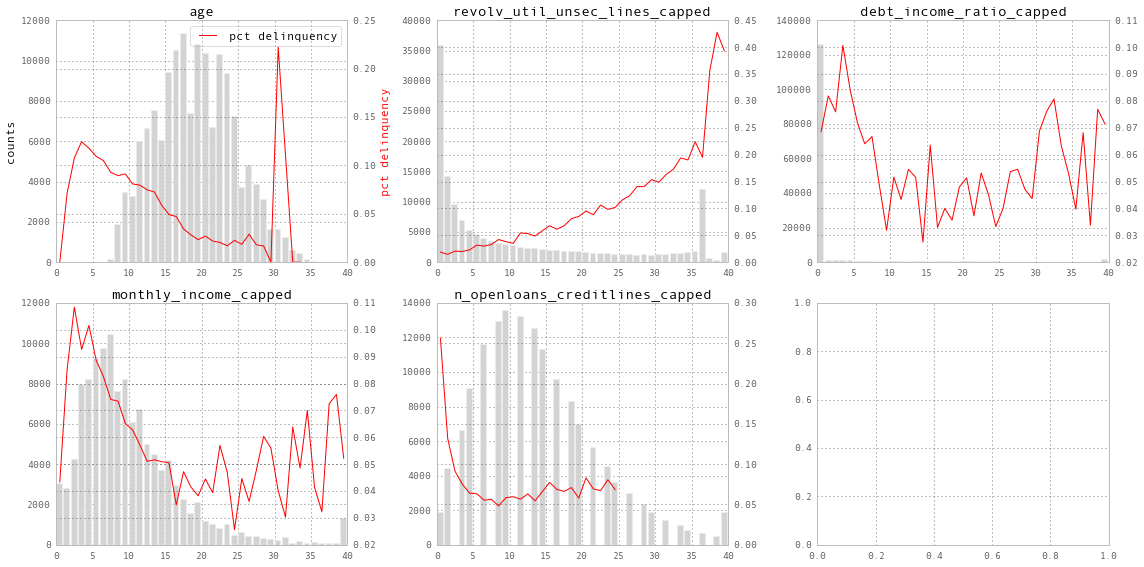

In [133]:
conti_col_names = [ u'age', u'revolv_util_unsec_lines_capped', u'debt_income_ratio_capped'\
    , u'monthly_income_capped', u'n_openloans_creditlines_capped']

sys.path.append('/Users/joyceduan/documents/git2/machine_learning/eda')
import plot_helper

fig = plot_helper.plot_ybinary_xnumerical(df2[conti_col_names], df2[yname], n_per_row=3, nbins = 40, figsize=(16,8))
fig.show()

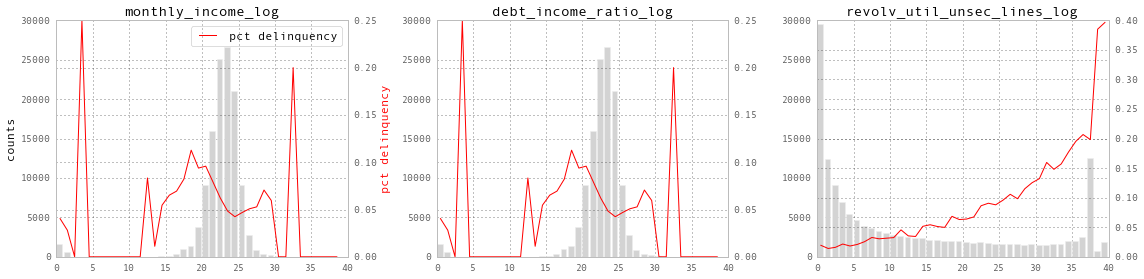

In [132]:
import math
df2['monthly_income_log'] = df2['monthly_income'].apply(lambda x: np.log(x+1))
df2['debt_income_ratio_log'] = df2['monthly_income'].apply(lambda x: np.log(x+1))
df2['revolv_util_unsec_lines_log'] = df2['revolv_util_unsec_lines_capped'].apply(lambda x: np.log(x+1))
conti_col_names = ['monthly_income_log','debt_income_ratio_log','revolv_util_unsec_lines_log' ]
fig = plot_helper.plot_ybinary_xnumerical(df2[conti_col_names], df2[yname], n_per_row=3, nbins = 40, figsize=(16,4))
fig.show()

In [ ]:
cat_col_names = [
    u'n_realestate_loans', \
   'n_dependents', u'n_30-59d_late', u'n_60-89d_late', u'n_90d_late']


In [160]:
def plot_cat_var(df, catx_names, y_name, figsize=(16,4), n_per_row=3, title = ''):
    nplots = len(catx_names)
    nrows_plot = nplots // n_per_row
    if nplots % n_per_row > 0:
        nrows_plot = nrows_plot + 1
    fig, axs = plt.subplots(nrows_plot, n_per_row, figsize=figsize)
    axs_flat = axs.flatten()
    for i, cat in enumerate(catx_names):
        ax = axs_flat[i]
        ax2 = ax.twinx()
        avg_pos = df.groupby(cat)[y_name].mean()
        avg_pos.plot(kind='bar', ax=ax2, color='r', alpha = 0.5, position = 0)
        
        cnt = df.groupby(cat)[y_name].sum()

        cnt.plot(kind='bar', color= 'darkgray', ax = ax, position = 1)
        ax.set_title(cat)
        width = 0.4

    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
 

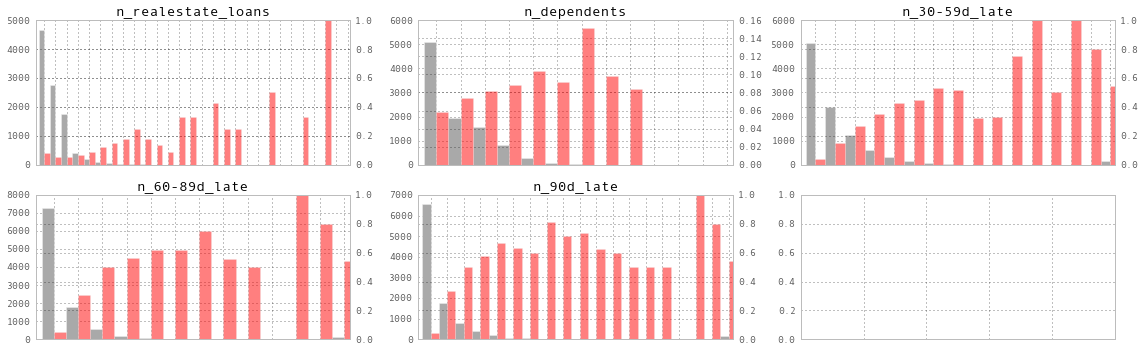

In [162]:
plot_cat_var(df2,cat_col_names,yname, figsize=(16,5))

## Interaction between continous variables

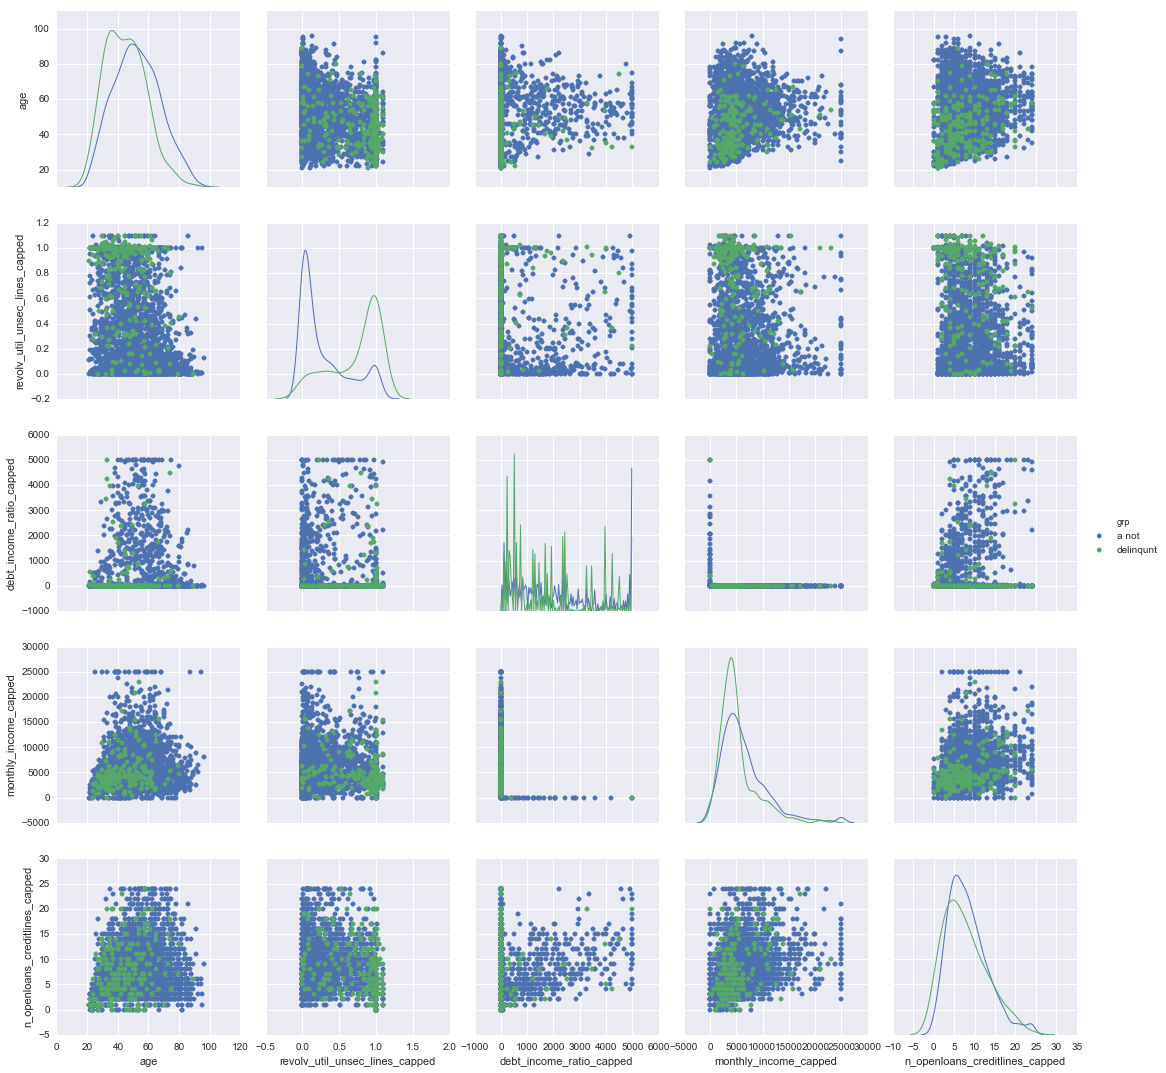

In [16]:
import seaborn as sns

sns.set()
n_samples = 3000
#colnames = [yname] + [t + '_capped'for t in conti_col_names]
# [ u'age', u'revolv_util_unsec_lines_capped', u'debt_income_ratio_capped'\
#    , u'monthly_income_capped', u'n_openloans_creditlines_capped']
df2['grp'] = df2[yname].apply(lambda x: 'delinqunt' if x == 1 else 'a not' )
#xnames_tmp = ['revolv_util_unsec_lines_capped', 'monthly_income_capped', 'grp']  
xnames_tmp = [ u'age', u'revolv_util_unsec_lines_capped', u'debt_income_ratio_capped'\
    , u'monthly_income_capped', u'n_openloans_creditlines_capped', 'grp']
colnames= [yname] + xnames_tmp
rows_sampled = random.sample(df.index, n_samples)
df_sample5k = df2.ix[rows_sampled, colnames]
sns.set()
g = sns.PairGrid(df_sample5k[xnames_tmp], diag_sharey=False, hue='grp')
#g = sns.PairGrid(df_sample5k[xnames_tmp], diag_sharey=False, hue=df_sample5k[yname])
g.map_diag(sns.kdeplot, lw=1)
g.map_lower(plt.scatter)
g.map_upper(plt.scatter)
g.add_legend()

In [194]:
print df_x_capped.columns

Index([u'age_capped', u'debt_income_ratio_capped', u'monthly_income_capped', u'n_30-59d_late_capped', u'n_60-89d_late_capped', u'n_90d_late_capped', u'n_dependents_capped', u'n_openloans_creditlines_capped', u'n_realestate_loans_capped', u'revolv_util_unsec_lines_capped'], dtype='object')


In [14]:
np.sum(df[yname])

10026